# Benchmark

---

This Notebook implements the code needed for Benchmarking algorithms for Project 1.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="/src/mygym/envs/Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env.brain_names

['BananaBrain']

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


###  3. Benchmark

In [6]:
import gym

import random
import torch
import numpy as np
from collections import deque
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from brains import FullyConnectedBrain
from brains import DuelingFullyConnectedBrain
from agents import QAgentGeneric

### Runner

In [9]:
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, quiet=False, save_solved=True, checkpoint_name='checkpoint', min_best = 15, save_best=False):
    """Runs the (Dueling) (Double) DQN Algorithm
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        quiet (bool): quiet mode, dont print output
        save_solved (bool): save the weight, when the environment is considered solved
        checkpoint_name (str): checkpoint name for saving good models
        min_best (int): the minimum threshold for saving the good models
        save_best (bool): save the good models or not, the average score must above min_best
    """
    scores = []                                           # list containing scores from each episode
    scores_window = deque(maxlen=100)                     # last 100 scores
    eps = eps_start                                       # initialize epsilon
    last_best = min_best
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # UPDATE THE NETWORK
            state = next_state                             # roll over the state to next time step
            score += reward                                # update the score
            if done:
                break
        scores_window.append(score)                        # save most recent score
        scores.append(score)                               # save most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        if not quiet: 
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
          if i_episode % 100 == 0:
              if not quiet: print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        average_score = np.mean(scores_window)
        if save_solved and average_score>=20.0:
          if not quiet: print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
          torch.save(agent.qnetwork_local.state_dict(), f'{checkpoint_name}-{i_episode}-solved.pth')
        
        if save_best and average_score>last_best:
          torch.save(agent.qnetwork_local.state_dict(), f'{checkpoint_name}-Best.pth')
          if not quiet: print(f'\nSaved Best with Average Score of {average_score}', end="")
          last_best = average_score

    return scores

### Benchmarking Helpers

In [10]:
def do_single_benchmark(agent, N, checkpoint_name="tmp", n_episodes=50, max_t=50):
  r = []
  for i in range(N):
    print(f'\rRunning Test #{i+1}', end="")
    r.append(dqn(vanilla_dqn_agent, n_episodes=n_episodes, max_t=max_t, checkpoint_name=checkpoint_name, save_best=True, min_best=17, quiet=True, save_solved=False))
    
  return r

In [11]:
def save_results(dict_of_scores, file_name):
  with open(file_name, 'wb') as f:
    pickle.dump(dict_of_scores, f)

In [12]:
def load_results(file_name):
  with open(file_name, 'rb') as f:
    return pickle.load(f)

### Actual Benchmarking Benchmarking

First, we create all agents needed to perform benchmarking.

In [13]:
# DQN
lb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device)
tb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device)

vanilla_dqn_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="dqn", local_brain=lb, target_brain=tb)

In [14]:
# Double DQN
lb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device)
tb = FullyConnectedBrain(state_size=37, action_size=4, seed=0, hidden_sizes=[128, 64, 16]).to(device)

double_dqn_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="double_dqn", local_brain=lb, target_brain=tb)

In [15]:
# Dueling DQN
lb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)
tb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)

dueling_vanilla_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="dqn", local_brain=lb, target_brain=tb)

In [16]:
# Dueling Double DQN
lb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)
tb = DuelingFullyConnectedBrain(state_size=37, action_size=4, seed=0, shared_hidden = [128, 64, 16], value_head=[32, 16], advantage_head=[32, 32]).to(device)

dueling_dobule_agent = QAgentGeneric(state_size=37, action_size=4, seed=0, update_rule="double_dqn", local_brain=lb, target_brain=tb)

## Actual Benchmark

In [17]:
def benchmark(list_of_agents, agent_names, N):
  results = {}
  
  for i, agent in enumerate(list_of_agents):
    print(f'\nBenchmarking {agent_names[i]}')
    r = do_single_benchmark(agent, N, f'From-Benchmark-{agent_names[i]}', n_episodes=2000, max_t=1000)
    results[agent_names[i]] = r
    
  return results

In [18]:
agents = [vanilla_dqn_agent, double_dqn_agent, dueling_vanilla_agent, dueling_dobule_agent]
agent_names = ['DQN', 'DDQN', 'Dueling DQN', 'Dueling DDQN']

In [19]:
b_results = benchmark(agents, agent_names, 5)


Benchmarking DQN
Running Test #5
Benchmarking DDQN
Running Test #5
Benchmarking Dueling DQN
Running Test #5
Benchmarking Dueling DDQN
Running Test #5

In [20]:
# Save the results (scores) for Report

save_results(b_results, 'benchmark_scores_5x_1000_1000.pkl')

In [21]:
# Save Final Weights

for i, agent in enumerate(agents):
  torch.save(agent.qnetwork_local.state_dict(), f'{agent_names[i]}-BENCHMARK.pth')

### Plotting

In [28]:
def plot_benchmark(benchmark_results, N):
  """Plot Benchmarks
  
  Params
  ======
        benchmark_results (dict): dictionary of results
        N (int): moving average window size
  """
  sns.set(style='whitegrid', context='notebook', palette='icefire')
  fig = plt.figure(figsize=(16, 8))
  ax = fig.add_subplot(111)
  
  colors = ['red', 'blue', 'yellow', 'green']
  
  for i, K in enumerate(benchmark_results.keys()):
    current_benchmark = benchmark_results[K]
  
    moving_average  = [np.convolve(t, np.ones((N,))/N, mode='valid') for t in current_benchmark] 
  
    x1 = np.asarray(moving_average).mean(axis=0)
    x2 = np.asarray(moving_average).max(axis=0)
    x3 = np.asarray(moving_average).min(axis=0)

    plt.plot(x1, color=colors[i], label=K)
    plt.plot(x2, color=colors[i], alpha=0.15, linestyle=':')
    plt.plot(x3, color=colors[i], alpha=0.15, linestyle=':')

    plt.fill_between(range(len(x1)), x2, x3, alpha=0.05, color=colors[i])
  
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
  plt.title("Benchmark Results")
  plt.show()

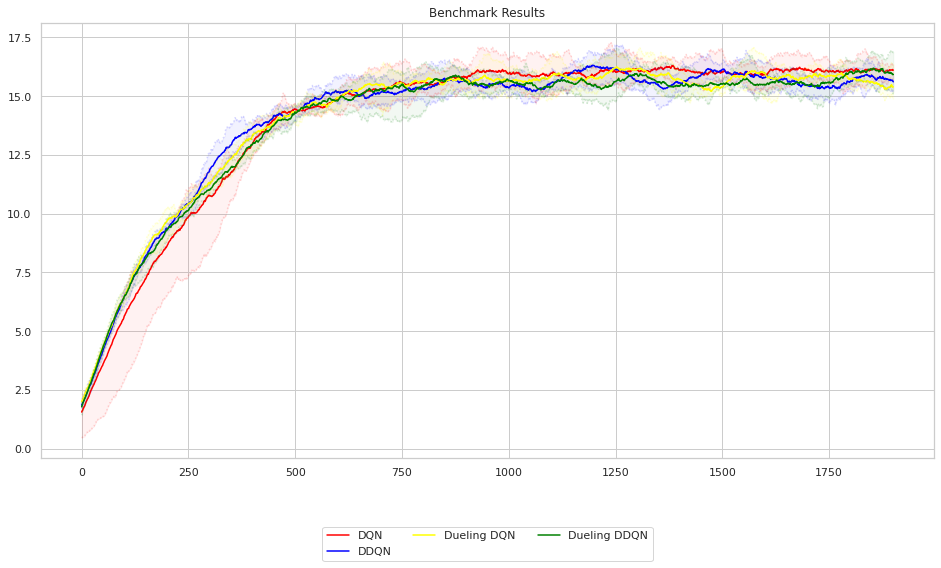

In [29]:
plot_benchmark(b_results, N=100)

In [ ]:
env.close()

### See ``Rerport.ipynb`` for more results